# Test EfficientDet model and BiFPNs

In [1]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch
import torch.nn.functional as F
from utils.ssd_model import DBox, Detect

In [2]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    conf_layers = []

    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]
    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [3]:
class BiFPN(nn.Module):
    def __init__(self,
                num_channels):
        super(BiFPN, self).__init__()
        self.num_channels = num_channels

    def forward(self, inputs):
        num_channels = self.num_channels
        P3_in, P4_in, P5_in, P6_in, P7_in = inputs
        for input in inputs:
            print(input.size())

        P7_up = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P7_in)
        scale = (P6_in.size(3)/P7_up.size(3))
        
        P6_up = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P6_in+self.Resize(scale_factor=scale)(P7_up))
        scale = (P5_in.size(3)/P6_up.size(3))
        P5_up = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P5_in+self.Resize(scale_factor=scale)(P6_up))
        scale = (P4_in.size(3)/P5_up.size(3))
        P4_up = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0)(P4_in+self.Resize(scale_factor=scale)(P5_up))
        scale = (P3_in.size(3)/P4_up.size(3))
        P3_out = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0)(P3_in+self.Resize(scale_factor=scale)(P4_up))

        # downsample by interpolation
        #print("P6_up scale",scale)
        P4_out = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P4_in + P4_up+F.interpolate(P3_out, P4_up.size()[2:]))
        P5_out = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P5_in + P5_up+F.interpolate(P4_out, P5_up.size()[2:]))
        P6_out = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P6_in + P6_up+F.interpolate(P5_out, P6_up.size()[2:]))
        P7_out = self.Conv(in_channels=num_channels, out_channels=num_channels, kernel_size=1, stride=1, padding=0, groups=num_channels)(P7_in + P7_up+F.interpolate(P6_out, P7_up.size()[2:]))
        return P3_out, P4_out, P5_out, P6_out, P7_out

    @staticmethod
    def Conv(in_channels, out_channels, kernel_size, stride, padding, groups = 1):
        features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU()
        )
        return features 
    @staticmethod
    def Resize(scale_factor=2, mode='bilinear'):
        upsample = nn.Upsample(scale_factor=scale_factor, mode=mode)
        return upsample

In [4]:
class EfficientDet(nn.Module):
    def __init__(self, phase, cfg, verbose=False, backbone="efficientnet-b0", useBiFPN=True):
        super(EfficientDet, self).__init__()
        # meta-stuff
        self.phase = phase
        self.num_classes = cfg["num_classes"]
        self.verbose=verbose
        # make Dbox
        dbox = DBox(cfg)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dbox_list = dbox.make_dbox_list()        
        # use Detect if inference
        if phase == "inference":
            self.detect = Detect()
        ratio = 1
        
        # define backbone
        model = EfficientNet.from_pretrained(backbone)
        self.layer0 = nn.Sequential(model._conv_stem, model._bn0)
        self.layer2 = nn.Sequential(model._blocks[0],model._blocks[1],model._blocks[2],model._blocks[3])
        self.layer3 = nn.Sequential(model._blocks[4],model._blocks[5])
        self.layer4 = nn.Sequential(model._blocks[6],model._blocks[7],model._blocks[8],model._blocks[9],model._blocks[10],model._blocks[11])
        self.layer5 = nn.Sequential(model._blocks[12],model._blocks[13],model._blocks[14],model._blocks[15])
        # Bottom-up layers
        #self.conv5 = nn.Conv2d( 320, 256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d( 320, 256, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d( 256, 256, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d( 256, 256, kernel_size=3, stride=1, padding=0)
        # Top layer
        self.toplayer = nn.Conv2d(320, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)        
        # Lateral layers
        self.latlayer1 = nn.Conv2d( 80, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 40, 256, kernel_size=1, stride=1, padding=0)
        # loc, conf layers
        self.loc, self.conf = make_loc_conf(self.num_classes, cfg["bbox_aspect_num"])
        # FPNs
        self.usebifpn=useBiFPN
        if BiFPN:
            self.BiFPN=BiFPN(256)
        
    def forward(self, x):
        # efficientnet layers
        x = self.layer0(x)
        p3 = self.layer2(x) # 37x37       
        p4 = self.layer3(p3) # 18x18       
        p5 = self.layer4(p4)
        p5 = self.layer5(p5)
        
        if self.verbose:
            print("layerc3:", p3.size())
            print("layerc4:", p4.size())
            print("layerc5:", p5.size())
            
        # non-efficientnet layers
        p6 = self.conv6(p5) # 5x5
        p7 = self.conv7(F.relu(p6)) # 3x3
        p8 = self.conv8(F.relu(p7)) # 1x1
        
        # TODO: implement BiFPN
        if not self.usebifpn:
            # Top-down
            p5 = self.toplayer(p5) # 10x10
            p4 = self._upsample_add(p5, self.latlayer1(p4)) # 19x19
            p3 = self._upsample_add(p4, self.latlayer2(p3)) # 38x38
            # Smooth
            p4 = self.smooth1(p4)
            p3 = self.smooth2(p3)

            # make loc and confs.
            sources = [p3, p4, p5, p6, p7, p8]
        else:
            # BiFPNs
            # Top-down
            p5 = self.toplayer(p5) # 10x10
            p4 = self._upsample_add(p5, self.latlayer1(p4)) # 19x19
            p3 = self._upsample_add(p4, self.latlayer2(p3)) # 38x38
            sources = [p3, p4, p5, p6, p7]
            sources = self.BiFPN(sources)
        
        # look at source size
        if self.verbose:
            for source in sources:
                print("layer size:", source.size())
        
        # make lists
        loc = list()
        conf = list()        
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
        
        # locとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        
        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)
        # これで後段の処理につっこめるかたちになる。
        
        output = (loc, conf, self.dbox_list)
        
        if self.phase == "inference":
            # Detectのforward
            return self.detect(output[0], output[1], output[2].to(self.device))
        else:
            return output
    
    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

In [5]:
cfg = {
        'num_classes': 21,  # 背景クラスを含めた合計クラス数
        'input_size': 512,  # 画像の入力サイズ
        'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
        'feature_maps': [64, 32, 16, 8, 4, 2],  # 各sourceの画像サイズ
        'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
        'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
        'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
        'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    }
back = EfficientDet("train", cfg, verbose=True)
x = torch.rand([1,3,512,512])
out = back(x)
print(out[0].size())
print(out[1].size())

Loaded pretrained weights for efficientnet-b0
layerc3: torch.Size([1, 40, 64, 64])
layerc4: torch.Size([1, 80, 32, 32])
layerc5: torch.Size([1, 320, 16, 16])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 4, 4])
layer size: torch.Size([1, 256, 64, 64])
layer size: torch.Size([1, 256, 32, 32])
layer size: torch.Size([1, 256, 16, 16])
layer size: torch.Size([1, 256, 8, 8])
layer size: torch.Size([1, 256, 4, 4])
torch.Size([1, 24512, 4])
torch.Size([1, 24512, 21])


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Set up MS-coco dataset

In [6]:
from dataset.coco import COCODetection
import torch.utils.data as data
from utils.dataset import VOCDataset, COCODatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

batch_size = 2

In [7]:
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

## DatasetTransformを適応
transform = COCODatasetTransform(input_size, color_mean)

In [8]:
dataset = COCODetection("../data/coco/", image_set="val2014", phase="train", transform=transform)

loading annotations into memory...
Done (t=4.75s)
creating index...
index created!


In [9]:
train_dataloader = data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True,  num_workers=8, pin_memory=True, collate_fn=od_collate_fn)

In [10]:
# 動作の確認
batch_iterator = iter(train_dataloader)  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].shape)  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([2, 3, 300, 300])
2
torch.Size([5, 5])


In [11]:
import numpy as np
a = np.random.randn(100,100,3)
np.mean(a,axis=(0,1))
images = images.numpy()[0,:,:,:].transpose([1,2,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


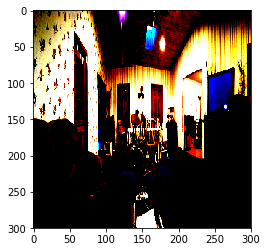

In [12]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(images)   # pltはRGBで表示する.
plt.show()